In [1]:
# dependencies for file reading
import json
import sys
import itertools
import numpy as np
import os
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import soundfile as sf

import librosa # conda install -c conda-forge librosa
import seaborn as sns

# managing parameters
from parammanager import paramManager
from sonyganformat import sonyGanJson
#from Tf_record import tfrecordManager

#Synth Interface (SI)
from genericsynth import synthInterface as SI # the base model for all synths, also some utilities 

In [2]:
mysr=200
length_secs=4
cf=5

nocts=10
length=round(length_secs*mysr)
octs=np.linspace(-nocts/2, nocts/2, length, True)
freqs=cf*np.power(2.,octs)
steps=freqs/mysr
cumstep=np.cumsum(steps)
sig=np.sin(cumstep)



#### Demo of synth interface using the single pop synth 

Note: Chirp and ChirpPatternSynth are both synths that derive from the SI.MySoundModel class (and thus have the interface for parameter setting/getting as well as the generate() function for creating audio.

Here we load Chirp just to see the interface in action. Normally it would only be used by ChirpPatternSynth, and not loaded in a notebook or data set generating program. 

In [3]:
from Chirp import Chirp   # This is the single-event synth that ChirpPatternSynth uses [loading just for viz purposes]
foosynth=Chirp(440, 1)   # can (optionally) set params for a synth when you create an instance

foosynth.setParam('amp', 1) # Can set any synth parameter with setParam()
foosynth.getParams()    # Get a param values. 

['cf', 'nocts', 'comps', 'amp']

In [4]:
fmin = foosynth.getParam('cf', "min")  # by default, getParam would get val, but here we ask for its min
print("min val of synth param f0 is {}".format(fmin))

foosynth.setParam('cf', 1000)   #setParamNorm uses [0,1] range 
foosynth.setParam('nocts', 2)
foosynth.setParam('comps', 2)

foosynth.printParams()    # Get a param values. 

min val of synth param f0 is 100
Name:  cf  Default value :  1000  Max value  2000  Min value  100
Name:  nocts  Default value :  2  Max value  3  Min value  -3
Name:  comps  Default value :  2  Max value  5  Min value  1
Name:  amp  Default value :  1  Max value  1  Min value  0


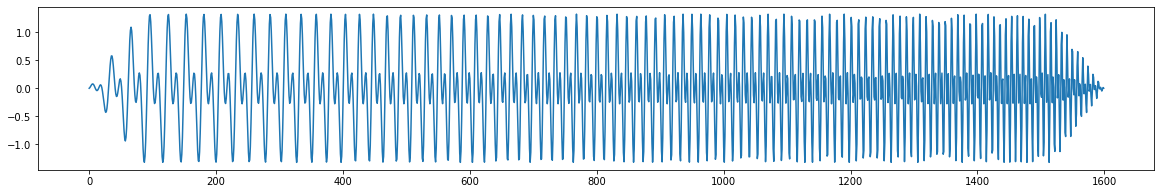

In [5]:
sig=foosynth.generate(.1, .75)   # all synths use generate to create audio. Parameter is length in seconds

plt.figure(figsize=(20,3))
plt.plot(sig)
display(Audio(sig, rate=16000, autoplay=True))

In [6]:
# A handy function to print the names and range of parameters using Synth
foosynth.printParams()

Name:  cf  Default value :  1000  Max value  2000  Min value  100
Name:  nocts  Default value :  2  Max value  3  Min value  -3
Name:  comps  Default value :  2  Max value  5  Min value  1
Name:  amp  Default value :  1  Max value  1  Min value  0


#### Demo of synth interface using the ChirpPatternSynth

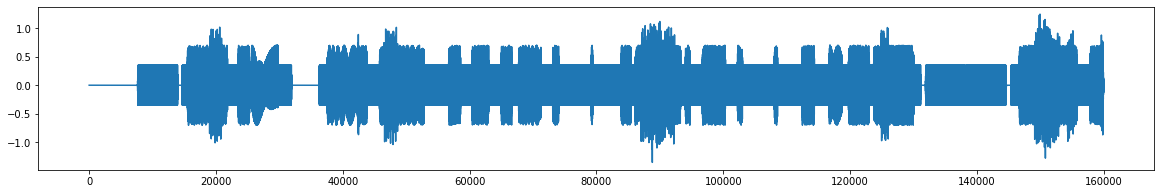

In [7]:
from ChirpPatternSynth import PatternSynth

barsynth=PatternSynth()
barsynth.setParam("rate",2) # will make 2^1 events per second
barsynth.setParam("irreg", 1)
barsynth.setParam("nocts", -3)
barsynth.setParam("evdur", .4)

barsynth.setParam("cf", 880)
barsynth.setParam("cfsd", 0)

barsig=barsynth.generate(10)      # will generate n seconds of sound
plt.figure(figsize=(20,3))
plt.plot(barsig)
display(Audio(barsig, rate=16000, autoplay=True))

### Visualize distribution of events

Notice that this code is model-independent (uses only SI utility function, no synth methods)

number of events is 8000


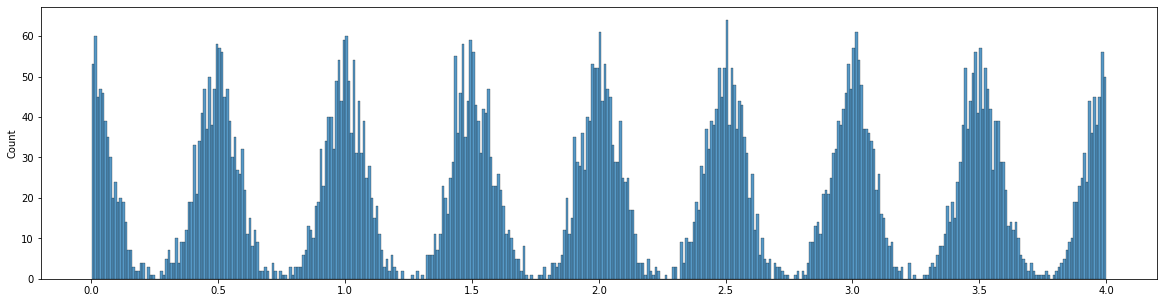

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

events=[]
for i in range(1000) :  #repeat to get enought samples to see the shape of the distribution
                                        #params: (events per second = 2^p1,     sd = .1*p2*10^p2,     seconds)
    events.extend(SI.noisySpacingTimeList(1, .5, 4))
print("number of events is {}".format(len(events)))
plt.figure(figsize=(20,5))
sns.histplot(events, bins=400)
plt.show()


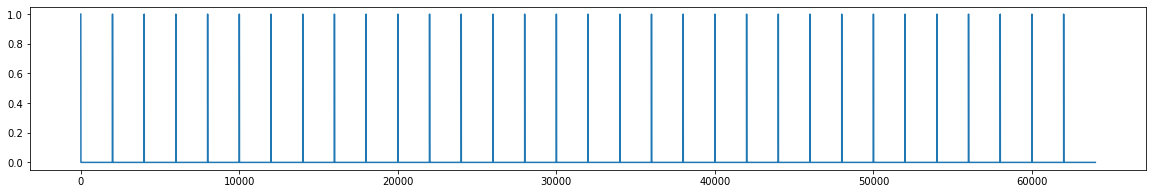

In [9]:
   #params: (events per second = 2^p1,     sd = .1*p2*10^p2,     seconds=p3)
elist = SI.noisySpacingTimeList(3, 0, 4)
esig = SI.timeList2Sig(elist,16000,4)

plt.figure(figsize=(20,3))
plt.plot(esig)

#### Demo of synth interface for dataset generation
1) Reading parameters from config_file.json <br>
2) Enumerating parameter values. <br>
3) Generating datasets from enumerated parameters

In [10]:
if False :
    paramArr = []
    data = []

    config_file = './config_file.json'
    with open(config_file) as json_file:
        data = json.load(json_file)
        print("Reading parameters for generating ", data['soundname'], " texture.. ")
        for p in data['params']:
            print(p['pname'], ' Min: ', p['minval'], ' Max: ', p['maxval'])
            paramArr.append(p)

In [11]:
if False :
        # Config file Variables
    sr = data['samplerate']
    soundName = data["soundname"]
    outPath = data["outPath"]
    recordFormat = data["recordFormat"]
    paramRange = data["paramRange"]
    soundDuration = data["soundDuration"]
    numVariations = data["numVariations"]

In [12]:
if False :
    '''2 arrays for normalised and naturalised ranges'''
    userRange = []
    synthRange = []

    if paramRange == "Norm":
        for p in paramArr:
            userRange.append(np.linspace(p["minval"], p["maxval"], p["nvals"], endpoint=True))    
        for p in paramArr:
            synthRange.append(np.linspace(p["minval"], p["maxval"], p["nvals"], endpoint=True))
    else:
        for p in paramArr:
            userRange.append(np.linspace(p["minval"], p["maxval"], p["nvals"], endpoint=True))    
        for p in paramArr:
            synthRange.append(np.linspace(p["minval"], p["maxval"], p["nvals"], endpoint=True))

    userParam = list(itertools.product(*userRange))
    synthParam = list(itertools.product(*synthRange))
    userParam

#### Generate wav and param files for every parameter combination (listed above)